# Clustering IATI results data 

First, let's ingest the data:

In [7]:
% matplotlib inline
from __future__ import print_function

from time import time
import os
import xml
from pprint import pprint as pp

import pandas as pd
import matplotlib.pyplot as plt
import xmltodict

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

In [5]:
#Load some raw data - This is from the World Bank and we know it has useful results data to extract
for xml_name in os.listdir('result'):
    iati_filename = 'result/' + xml_name
    with open(iati_filename,'r') as f:
        json=xmltodict.parse(f)
        print(iati_filename)


result/agresult0.xml
result/agresult1.xml
result/agresult2.xml


In [181]:
#Same code as above, but just loading the one smallest doc
iati_filename='result/agresult2.xml'
with open(iati_filename,'r') as f:
    test_json=xmltodict.parse(f)

In [183]:
#Check out a specific record
for i in test_json['iati-activities']['iati-activity']:
    #print(i)
    if i['iati-identifier']=='US-EIN-13-3287064NAM-AAH-CI-11-2131':
        output=i
    break

output

OrderedDict([(u'@xml:lang', u'en'),
             (u'@last-updated-datetime', u'2014-10-20T18:43:21Z'),
             (u'@linked-data-uri', u'https://www.ngoaidmap.org/projects/2130'),
             (u'@xmlns:interactions-ngoaidmap', u'https://www.ngoaidmap.org/'),
             (u'@xmlns:xsi', u'http://www.w3.org/2001/XMLSchema-instance'),
             (u'@xmlns:xsd', u'http://www.w3.org/2001/XMLSchema'),
             (u'@interactions-ngoaidmap:records-returned', u'154'),
             (u'@interactions-ngoaidmap:total-records-available', u'154'),
             (u'@interactions-ngoaidmap:record-offset', u'0'),
             (u'@generated-datetime', u'2017-02-13T02:39:26+00:00'),
             (u'@version', u'2.01'),
             (u'@linked-data-default', u'https://www.ngoaidmap.org'),
             (u'iati-identifier', u'US-EIN-13-3287064NAM-AAH-CI-11-2130'),
             (u'reporting-org',
              OrderedDict([(u'@ref', u'US-EIN-13-3287064NAM'),
                           (u'@type', u'21

In [57]:
test_json['iati-activities']['iati-activity'][0].keys()
#test_result=test_json['iati-activities']['iati-activity'][0]['result']

[u'@xml:lang',
 u'@last-updated-datetime',
 u'@linked-data-uri',
 u'@xmlns:interactions-ngoaidmap',
 u'@xmlns:xsi',
 u'@xmlns:xsd',
 u'@interactions-ngoaidmap:records-returned',
 u'@interactions-ngoaidmap:total-records-available',
 u'@interactions-ngoaidmap:record-offset',
 u'@generated-datetime',
 u'@version',
 u'@linked-data-default',
 u'iati-identifier',
 u'reporting-org',
 u'title',
 u'description',
 u'participating-org',
 u'other-identifier',
 u'activity-status',
 u'activity-date',
 u'contact-info',
 u'recipient-country',
 u'location',
 u'sector',
 u'transaction',
 u'document-link',
 u'result']

In [153]:
len(test_json['iati-activities']['iati-activity'])

800

In [155]:
def listify(field):
    """We'll need to ensure fields are consistently formatted to be able to parse them correctly"""
    if type(field)!=list:
        return [field]
    else:
        return field
    
def get_narratives(field):
    """Interesting text data in IATI typically lives in a sub-field called 'narrative', 
    so we'll want to pull this out as a bag-of-words.
    """
    corpus=[]
    for sub_result in field:
        corpus.append(sub_result['narrative'])
    corpus=u' '.join(corpus)
    return corpus

def get_results(field):
    """For results data, we'll pull out both titles and nat"""
    corpus=[]
    for sub_result in field:
        try:
            corpus.append(sub_result['title']['narrative'])
        except KeyError:
            pass
        try:
            corpus.append(sub_result['indicator']['title']['narrative'])
        except KeyError:
            pass
    corpus=u' '.join(corpus)
    return corpus

#Pull everything out and populate in dataframe (see cell below)
for num,i in enumerate(test_json['iati-activities']['iati-activity']):
    identifier=i['iati-identifier']
    description=listify(i['description'])
    description_corpus=get_narratives(title)
    
    title=listify(i['title'])
    title_corpus=get_narratives(title)
    
    result=listify(i['result'])
    result_corpus=get_results(result)

    record={'iati-identifier':identifier,'title':title_corpus,'description':description_corpus,'result':result_corpus}
    df2=pd.DataFrame(record,index=[identifier])
    df=df.append(df2)
    

In [154]:
#Run cell above, then run this to intitialize DF, then run cell above again
print(identifier)
print(title_corpus)
print(description_corpus)
print(result_corpus)

test={'iati-identifier':identifier,'title':title_corpus,'description':description_corpus,'result':result_corpus}

df=pd.DataFrame(test,index=['test'])

XM-DAC-41140-200988
PRRO-SYCO-Assistance to the population affected by unrest in  Syria
Réponse d'urgence à l'insécurité alimentaire dans l'ouest de la RCI suite aux violences post électorales
Total Outputs Beans - White Total Outputs Bulgur Wheat Total Outputs Chickpeas Total Outputs Rice - Brokens 5% Total Outputs Salt - Iodized Total Outputs Split Lentils - Red Total Outputs Sugar - White Total Outputs Vegetable Oil - Sunflower Total Outputs Wheat - Flour Total Outputs Date Bars


In [157]:
df.head()

,description,iati-identifier,result,title
test,Réponse d'urgence à l'insécurité alimentaire d...,XM-DAC-41140-200988,Total Outputs Beans - White Total Outputs Bulg...,PRRO-SYCO-Assistance to the population affecte...
US-EIN-13-3287064NAM-AAH-CI-11-2130,PRRO-SYCO-Assistance to the population affecte...,US-EIN-13-3287064NAM-AAH-CI-11-2130,Project Reach Project Reach (individuals),Relance agricole post crise dans l'ouest de la...
US-EIN-13-3287064NAM-AAH-CI-11-2131,Relance agricole post crise dans l'ouest de la...,US-EIN-13-3287064NAM-AAH-CI-11-2131,Project Reach Project Reach (individuals),Réponse d'urgence à l'insécurité alimentaire d...
US-EIN-13-3287064NAM-AAH-CI-11-2133,Réponse d'urgence à l'insécurité alimentaire d...,US-EIN-13-3287064NAM-AAH-CI-11-2133,Project Reach Project Reach (individuals),Soutien d'urgence aux moyens d'existence et à ...
US-EIN-13-3287064NAM-AAH-CI-11-3050,Soutien d'urgence aux moyens d'existence et à ...,US-EIN-13-3287064NAM-AAH-CI-11-3050,Project Reach Project Reach (individuals),Assistance to Populations Affected by Post-Ele...


In [165]:
data=df #rename so code below works conveniently
data.ix['test']

description        Réponse d'urgence à l'insécurité alimentaire d...
iati-identifier                                  XM-DAC-41140-200988
result             Total Outputs Beans - White Total Outputs Bulg...
title              PRRO-SYCO-Assistance to the population affecte...
Name: test, dtype: object


# Agglomerative Clustering

Agglomerative clustering is a bottom-up method, in which each element is matched to its most similar element or group of elements until everything's been matched together.  It's not used as frequently as some of the more common clustering approaches because it doesn't scale well, but I wanted to play with it, so here we are.

The cool thing about this approach is that we can visualize how "close" different organizations are via a dendrogram, which can be useful both for making it easier to see trends and to do sanity checks.

NB: This code is recycled from a similar approach I took to create the data for [this blog post](https://chewychunks.wordpress.com/2016/10/07/a-complete-ngo-ecosystem-map-for-kenya-2010-2013/)

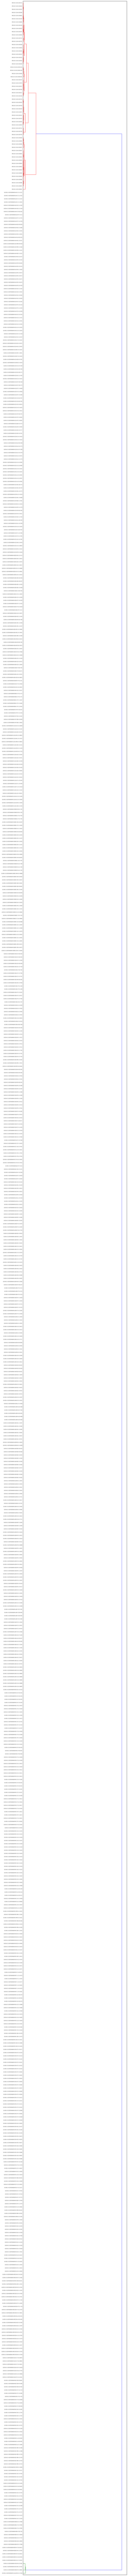

In [167]:
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity

#Convert pandas series to lists for easier plotting
titles=list(data['iati-identifier'])
text=list(data['result'])

vectorizer = TfidfVectorizer(max_df=0.5,min_df=20)
tfidf_matrix = vectorizer.fit_transform(text) 
dist = 1 - cosine_similarity(tfidf_matrix)

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(10, 200)) # set size
ax = dendrogram(linkage_matrix, 
                orientation="right", 
                color_threshold=0.28*max(linkage_matrix[:,2]), #0.143*max(linkage_matrix[:,2]), == 25 groups
                distance_sort='ascending', 
                labels=titles); # truncate_mode='level', p=4 -- will cut off end labels and just show the bigger branches (N)

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

In this dataset, we see a cluster of varied (but related) results (shown in red), a bunch of activities that have exactly the same articulation of their results, and a small outlier group (shown in green). Roughly these correspond to activities that list out their results in terms of specific crops vs those that don't ("Project Reach - Individuals"). I only ran this on one small example, but I believe it's a representative one given that the World Bank is known for reporting high-quality results data (at least relative to most other IATI publishers)

More digging would be useful to make this really reliable, but I think the quick takeaway here is that indexing activity results by "type" isn't likely to be useful.  However, having a simple filter functionality to indicate "granularity" of activity results, might be a helpful way of tagging the output of different organizations.